## Importing Necessary Libraries and Functions

The first thing we need to do is import the necessary functions and libraries that we will be working with throughout the topic. We should also go ahead and upload all the of the necessary data sets here instead of loading them as we go. We will be using energy production data from PJM Interconnection. They are a regional transmission organization that coordinates the movement of wholesale electricity in parts of the United States. Specifically, we will be focused on a region of Pennsylvania. We will also be using temperature data collected from the National Oceanic and Atmospheric Assocation (NOAA).

In [ ]:
!conda update -n base -c defaults conda

!conda install pandas -y
!conda install numpy -y
!conda install matplotlib -y
!conda install statsmodels -y

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

Notice how we added an additional module above called ```statsmodels```. We need to build regression models in this milestone and so we will need the statsmodels module to do so. It is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration.

This milestone builds off the previous ones so we should complete the following steps to the first milestone again to have our data prepped and ready to go!

## Preparing the Energy and Temperature Data

First we need to load our weather and energy data sets for cleaning. Let's use the pandas library and the ```read.csv``` function to do this.

In [3]:
# Loading the Needed Data Sets 
weather = pd.read_csv('.../hr_temp_20170201-20200131_subset.csv')
energy = pd.read_csv('.../hrl_load_metered - 20170201-20200131.csv')


It is always good practice to take a look at the first few observations of the data set to make sure that everything looks like how we expected it to when we read in our CSV file. Let's use the ```head``` function for this.

In [4]:
weather.head()

,STATION,DATE,REPORT_TYPE,SOURCE,HourlyDryBulbTemperature
0,72520514762,2017-02-01T00:53:00,FM-15,7,37.0
1,72520514762,2017-02-01T01:53:00,FM-15,7,37.0
2,72520514762,2017-02-01T02:53:00,FM-15,7,36.0
3,72520514762,2017-02-01T03:53:00,FM-15,7,36.0
4,72520514762,2017-02-01T04:53:00,FM-15,7,36.0


Perfect! We have temperature as well as time. There are some other pieces of information like the station number, source of the reading and reading type, but we don't need those.

Let's take a look at the first few observations of the energy data as well!

In [5]:
energy.head()

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,2/1/2017 5:00,2/1/2017 0:00,RFC,WEST,DUQ,DUQ,1419.881,True
1,2/1/2017 6:00,2/1/2017 1:00,RFC,WEST,DUQ,DUQ,1379.505,True
2,2/1/2017 7:00,2/1/2017 2:00,RFC,WEST,DUQ,DUQ,1366.106,True
3,2/1/2017 8:00,2/1/2017 3:00,RFC,WEST,DUQ,DUQ,1364.453,True
4,2/1/2017 9:00,2/1/2017 4:00,RFC,WEST,DUQ,DUQ,1391.265,True


Great! Again, we have the important information of time as well as megawatt (MW) readings per hour. Again, there are some other varibales that we won't end up using in this data set as well.

Let's get rid of the variables we don't need and combine the variables that we do need into one pandas data frame. Dictionaries are an easy way of doing this. Here, we are pulling the MW column from the energy data set as well as the temperature and date columns from the weather data set. These data sets already line up on time which makes this much easier.

In [6]:
d = {'MW': energy['mw'], 'Temp': weather['HourlyDryBulbTemperature'], 'Date': weather['DATE']}

Now let's create our pandas data frame.

In [7]:
df = pd.DataFrame(d)

One of the problems when loading a data set you want to run time series analysis on is the type of object Python sees for the "date" variable. Let's look at the pandas data frame data types for each of our variables.

In [8]:
print(df.dtypes)

MW      float64
Temp    float64
Date     object
dtype: object


Here we can see that the Date variable is a general object and not a "date" according to Python. We can change that with the pandas function ```to_datetime``` as we have below.

In [9]:
df['Date'] = pd.to_datetime(df['Date'])
print(df.dtypes)

MW             float64
Temp           float64
Date    datetime64[ns]
dtype: object


Good! Now that we have a ```datetime64``` object in our data set we can easily create other forms of date variables. The hour of day, day of week, month of year, and possibly even the year itself might all impact the energy usage. Let's extract these variables from our date object so that we can use them in our analysis. Pandas has some wonderful functionality to do this with the ```hour```, ```day```, ```dayofweek```, ```month```, and ```year``` functions. Then let's inspect the first few observations to make sure things look correct.

In [10]:
df['hour'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).hour
df['day'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).day
df['weekday'] = df['Date'].dt.dayofweek
df['month'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).month
df['year'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).year

df.head()

,MW,Temp,Date,hour,day,weekday,month,year
0,1419.881,37.0,2017-02-01 00:53:00,0,1,2,2,2017
1,1379.505,37.0,2017-02-01 01:53:00,1,1,2,2,2017
2,1366.106,36.0,2017-02-01 02:53:00,2,1,2,2,2017
3,1364.453,36.0,2017-02-01 03:53:00,3,1,2,2,2017
4,1391.265,36.0,2017-02-01 04:53:00,4,1,2,2,2017


Everything looks good in the first few observations above. If you still aren't convinced you could pull different pieces of the data frame to make sure that other observations are structured correctly.

Now we should set this Python date object as the index of our data set. This will make it easier for plotting as well as forecasting later. We can use the ```set_index``` function for this.

In [11]:
df = df.set_index('Date')

Good! Now that we have our data structured as we would like, we can start the cleaning of the data. First, let's check if there are any missing values in the temperature column. The ```is.null``` function will help us here.

In [12]:
sum(df['Temp'].isnull())

37

Looks like there are 37 missing values in our temperature data. We shoudl impute those. However, we don't just want to put the average temperature in these spots as the overall average across three years probably isn't a good guess for any one hour. The temperature of the hours on either side of the missing observation would be more helpful. Let's do a linear interpolation across missing values to help with this. This will essentially draw a straight line between the two known points to fill in the missing values. We can use the ```interpolate(method='linear')``` function for this.

In [13]:
df['Temp'] = df['Temp'].interpolate(method='linear')

Now let's see if we have any more missing temperature values.

In [14]:
sum(df['Temp'].isnull())

0

No more! Time to check if the energy data has any missing values.

In [15]:
sum(df['MW'].isnull())

0

No missing values there either! Perfect.

Now it is time to split the data into two pieces - training and testing. The training data set is the data set we will be building our model on, while the testing data set is what we will be reporting results on since the model wouldn't have seen it ahead of time. Using the date index we can easily do this in our data frame.

In [16]:
#Training and Validation Split #
train = pd.DataFrame(df['2017-01-01':'2019-12-31'])
test = pd.DataFrame(df['2020-01-01':'2020-01-31'])

Now let's look at the first few observations for our training data set.

In [17]:
train.head()

,MW,Temp,hour,day,weekday,month,year
Date,,,,,,,
2017-02-01 00:53:00,1419.881,37.0,0,1,2,2,2017
2017-02-01 01:53:00,1379.505,37.0,1,1,2,2,2017
2017-02-01 02:53:00,1366.106,36.0,2,1,2,2,2017
2017-02-01 03:53:00,1364.453,36.0,3,1,2,2,2017
2017-02-01 04:53:00,1391.265,36.0,4,1,2,2,2017


Everything looks good there!

Now let's do the same for our testing data set.

In [18]:
test.head()

,MW,Temp,hour,day,weekday,month,year
Date,,,,,,,
2020-01-01 00:53:00,1363.428,31.0,0,1,2,1,2020
2020-01-01 01:53:00,1335.975,29.0,1,1,2,1,2020
2020-01-01 02:53:00,1296.817,30.0,2,1,2,1,2020
2020-01-01 03:53:00,1288.403,30.0,3,1,2,1,2020
2020-01-01 04:53:00,1292.263,31.0,4,1,2,1,2020


Excellent! We now have our data cleaned and split. By combining and cleaning the data sets, we will make the exploration of these data sets as well as the modeling of these data sets much easier for the upcoming sections!

## Building Naive Energy Model

Now that we have recreated the pieces of milestone 1 that clean and split our data we can start the modeling phase of milestone 3.

First, let's review some of the findings we have from the first two milestones:
- Energy usage changes depending on month / season
- Energy usage changes depending on day of week
- Energy usage changes depending on hour of day
- Energy usage changes depending on outside temperature
- The relationship between temperature and energy usage appears quadratic in nature

Looking at this last bullet point, we need to create a quadratic variable on temperature as temperature in the model by itself won't be enough to model energy usage. It is always good practice to standardize (mean of 0 and standard deviation of 1) any variable you are going to raise to a higher power in a regression to help prevent multicollinearity problems. We can standardize the variable *Temp* by using the ```mean``` and ```std``` functions.

In [19]:
train['Temp_Norm'] = (train['Temp']-train['Temp'].mean())/train['Temp'].std()

Now that temperature is standardized (or normalized) we can just multiply it by itself to get our quadratic term.

In [20]:
train['Temp_Norm2'] = train['Temp_Norm']**2

Let's do a brief look at the first few observations in our training data set to make sure that things worked as expected.

In [21]:
train.head()

,MW,Temp,hour,day,weekday,month,year,Temp_Norm,Temp_Norm2
Date,,,,,,,,,
2017-02-01 00:53:00,1419.881,37.0,0,1,2,2,2017,-0.871499,0.759511
2017-02-01 01:53:00,1379.505,37.0,1,1,2,2,2017,-0.871499,0.759511
2017-02-01 02:53:00,1366.106,36.0,2,1,2,2,2017,-0.924494,0.854690
2017-02-01 03:53:00,1364.453,36.0,3,1,2,2,2017,-0.924494,0.854690
2017-02-01 04:53:00,1391.265,36.0,4,1,2,2,2017,-0.924494,0.854690


Great! Now we have the foundation of building a model. 

The naive energy model is just a linear regression model. It will use the terms that we already identified as potentially impacting the energy usage - hour of day, day of week, month of year, temperature, and temperature's quadratic term. The ```OLS.from_formula``` function in the statsmodels module will take care of this for us. We can then use the ```summary``` function to view our results.

In [22]:
results = sm.OLS.from_formula('MW ~ Temp_Norm + Temp_Norm2 + C(weekday) + C(hour) + C(month)', data=train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     MW   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     3180.
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:53:41   Log-Likelihood:            -1.5735e+05
No. Observations:               25536   AIC:                         3.148e+05
Df Residuals:                   25493   BIC:                         3.151e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1272.0274      5.426    2

From above it looks like all the variables appear to statistically be related to energy. Our model is off to a great start! Let's try to add additional terms to our model to improve it.

We already checked if month and temperature have separate impacts on energy usage. However, from the plots we saw earlier we also hypothesized that the effect of temperature was different in different months. Let's try to visualize that here. The following code highlights the months of January and July in our previous temperature by energy usage scatter plot.

C:\Users\adlabarr\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


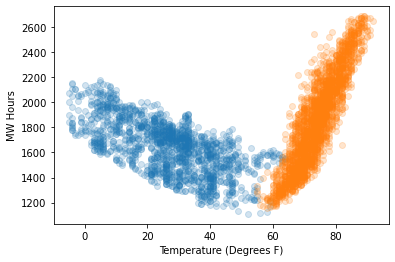

In [23]:
plt.subplot()
plt.scatter(train['Temp'].where(train['month'] == 1), train['MW'].where(train['month'] == 1), alpha = 0.2)
plt.xlabel('Temperature (Degrees F)')
plt.ylabel('MW Hours')

plt.subplot()
plt.scatter(train['Temp'].where(train['month'] == 7), train['MW'].where(train['month'] == 7), alpha = 0.2)
plt.xlabel('Temperature (Degrees F)')
plt.ylabel('MW Hours')

plt.show()

What does this show us? It shows exactly what we saw in milestone 2! It looks like in July, temperature has a different relationship with energy than in January. This different relationship is called an interaction. Luckily these can easily be added into models. Let's check if the same phenomenom exists across different hours. The following highlights the hours of midnight and noon for our temperature by energy scatter plot.

C:\Users\adlabarr\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


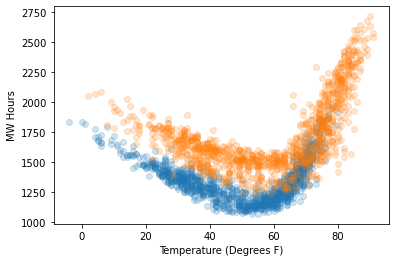

In [24]:
plt.subplot()
plt.scatter(train['Temp'].where(train['hour'] == 0), train['MW'].where(train['hour'] == 0), alpha = 0.2)
plt.xlabel('Temperature (Degrees F)')
plt.ylabel('MW Hours')

plt.subplot()
plt.scatter(train['Temp'].where(train['hour'] == 12), train['MW'].where(train['hour'] == 12), alpha = 0.2)
plt.xlabel('Temperature (Degrees F)')
plt.ylabel('MW Hours')

plt.show()

Again, it looks like some differences are occurring. Not surprisingly, people react more to temperature changes when they are awake as compared to when they are asleep. Let's incorporate these interactions with temperature (and its quadratic term) with hour and month. Also, in milestone 2 we noticed that hours were different on weekends compared to weekdays for energy usage so let's also interact hour and weekday.

In [25]:
results = sm.OLS.from_formula('MW ~ Temp_Norm*C(hour) + Temp_Norm2*C(hour) + Temp_Norm*C(month) + Temp_Norm2*C(month) + C(weekday)*C(hour)', 
                              data=train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     MW   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     1248.
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:53:46   Log-Likelihood:            -1.4774e+05
No. Observations:               25536   AIC:                         2.960e+05
Df Residuals:                   25287   BIC:                         2.980e+05
Df Model:                         248                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

All of those terms appeared significant too! Excellent. Now we have our naive energy model. It takes into account the hour of day, day of week, month of year, and the complicated relationship with temperature. 

Time to see how good our predictions are. One evaluation of model performance is the mean absolute percentage error (MAPE). This evaluates on average how far off are our predictions in terms of percentages. We need to get our predictions from our training data set. The ```fittedvalues``` function will do that for us. Then we can calculate the MAPE ourselves.

In [26]:
train['fitted'] = results.fittedvalues

train['APE'] = abs((train['MW']-train['fitted'])/train['MW'])*100
print("Training Naive Model MAPE is: ", train['APE'].mean())

Training Naive Model MAPE is:  3.5119541032055452


On average, our model incorrectly predicted energy usage by a little over 3.5%! That gives us a good baseline to compare our future models with.



In [27]:
test['Temp_Norm'] = (test['Temp']-test['Temp'].mean())/test['Temp'].std()
test['Temp_Norm2'] = test['Temp_Norm']**2

Let's forecast out our model by scoring the test data set with the linear regression we built. Remember, we don't want to build a model on the test data set, just run the observations through the equation we got from the training model. These are our January 2020 predictions! The ```predict``` function will help us with this. We need to specify which data set we are predicting as you see with the ```predict(test)``` below. Let's look at the first few observations from this prediction!

In [28]:
test['pred'] = results.predict(test)

test.head()

,MW,Temp,hour,day,weekday,month,year,Temp_Norm,Temp_Norm2,pred
Date,,,,,,,,,,
2020-01-01 00:53:00,1363.428,31.0,0,1,2,1,2020,-0.435454,0.189621,1301.224887
2020-01-01 01:53:00,1335.975,29.0,1,1,2,1,2020,-0.627840,0.394184,1296.150033
2020-01-01 02:53:00,1296.817,30.0,2,1,2,1,2020,-0.531647,0.282649,1280.104337
2020-01-01 03:53:00,1288.403,30.0,3,1,2,1,2020,-0.531647,0.282649,1292.227132
2020-01-01 04:53:00,1292.263,31.0,4,1,2,1,2020,-0.435454,0.189621,1334.757899


Good! Now let's plot our predictions for the test data set against the actual values.

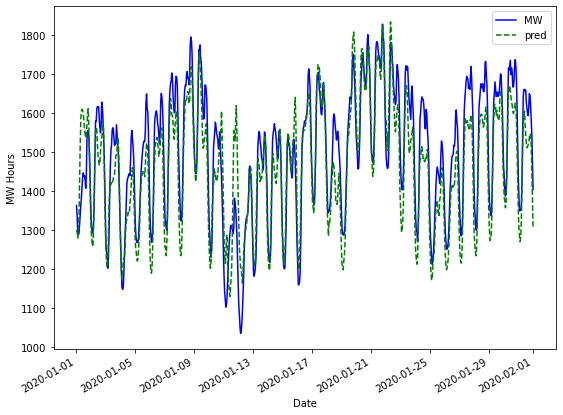

In [29]:
test['MW'].plot(color = 'blue', figsize=(9,7))

plt.ylabel('MW Hours')
plt.xlabel('Date')

test['pred'].plot(color = 'green', linestyle = 'dashed', figsize=(9,7))

plt.legend(loc="best");

plt.show()

Those look like rather good predictions! Let's see what the MAPE is on these.

In [30]:
test['APE'] = abs((test['MW']-test['pred'])/test['MW'])*100
print("Naive Model MAPE is: ", test['APE'].mean())

Naive Model MAPE is:  4.3947190107463365


Great! Remember, the MAPE is probably going to be higher because our model hasn't seen this data before. This is a great way to truly evaluate how well your model will do when deployed in a real world setting since you won't know energy data before you predict it. Looks like our model is only off by 4.4% on average.

The foundation is laid in this step. Model building can be complicated and sometimes it is hard to know when to stop. The best plan is to build a foundational model that you can try to build upon and/or outperform with later editions of your model. Without a good baseline, you won't know how good your final model is. These seasonal effects of hours of day, days of week, months of year as well as the temperature effects build a great first attempt at forecasting future energy usage.

This is a great initial model if your boss needs a check-in to see your progress. This model gets you a long way there since you have incorporated temperature's complicated relationship. In the next milestones you get to build on this great foundation to really show your boss what you can do!